# Invasive Plant Species Classifier

* Student names: Natasha Kacoroski, Jacob Crabb
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Miles Erickson, Greg Damico


## Load Libraries and Data

Import necessary libraries.

In [34]:
from sklearn_pandas import DataFrameMapper, FunctionTransformer, gen_features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from categorical_cleaning import *

# to avoid kernel shutdown with xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data. Manually removed backslash symbols while troubleshooting data import. 

In [2]:
plant_data = pd.read_csv("plants.csv", skiprows=9, low_memory=False)
plant_data.head()

,"outl0strokewidth0 strokec2 ""Accepted Symbol""",Synonym Symbol,Scientific Name,Common Name,Category,Duration,Growth Habit,Native Status,State Noxious Status,Active Growth Period,...,Propogated by Cuttings,Propogated by Seed,Propogated by Sod,Propogated by Sprigs,Propogated by Tubers,Seeds per Pound,Seed Spread Rate,Seedling Vigor,Small Grain,Vegetative Spread Rate
0,ABELI,NaN,Abelia,abelia,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABGR4,NaN,Abelia 'd7grandiflora,glossy abelia,Dicot,Perennial,Shrub,L48(I),NaN,"Spring, Summer, Fall",...,Yes,No,No,No,No,NaN,None,NaN,No,None
2,ABELM,NaN,Abelmoschus,okra,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABES,NaN,Abelmoschus esculentus,okra,Dicot,"Annual, Perennial","Subshrub, Forb/herb",L48(I)PR(I)VI(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIES,NaN,Abies,fir,Gymnosperm,NaN,NaN,"L48(I,N)CAN(N)SPM(N)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column information from https://plants.usda.gov/charinfo.html.

## Clean Data

Check for null values.

In [3]:
plant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38186 entries, 0 to 38185
Data columns (total 78 columns):
outl0strokewidth0 strokec2 "Accepted Symbol"    38186 non-null object
Synonym Symbol                                  66 non-null object
Scientific Name                                 38185 non-null object
Common Name                                     36115 non-null object
Category                                        38046 non-null object
Duration                                        27808 non-null object
Growth Habit                                    34269 non-null object
Native Status                                   38093 non-null object
State Noxious Status                            461 non-null object
Active Growth Period                            2027 non-null object
After Harvest Regrowth Rate                     1039 non-null object
Bloat                                           2063 non-null object
C:N Ratio                                       1840 non-nu

Lots of null values. There appears to be a subset of 2,063 entries that have most column data. Select subset to work with.

In [4]:
plant_data.dropna(subset=['Bloat'], inplace=True) # Bloat is first column with 2,063 entries
plant_data.reset_index(drop=True, inplace=True) # Reset index

'State Noxious Status' column contains target data. Add 'invasive' column where 1 is noxious and 0 is not.

In [5]:
plant_data['invasive'] = plant_data['State Noxious Status'].notnull().astype('int')

Split training and testing data.

In [6]:
X = plant_data.drop('invasive', axis=1)
y = plant_data['invasive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Build pipeline to clean and preprocess data.

In [15]:
# Clean categorical data by applying mapper that, if necessary,
# fills nulls, selects most common value, and simplifies unique values of column
cat_mapper = DataFrameMapper([
    (['Category'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(bin_category)], {'alias':'category'}),
    (['Duration'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(common_value)], {'alias':'duration'}),
    (['Growth Habit'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                        FunctionTransformer(common_value)], {'alias':'growth_habit'}),
    (['Active Growth Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                FunctionTransformer(num_of_growth_seasons)], {'alias':'num_of_growth_seasons'}),
    (['Bloat'], FunctionTransformer(binarize_bloat), {'alias':'bloat'}),
    (['C:N Ratio'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'cn_ratio'}),
    (['Coppice Potential'], None, {'alias':'cop_potential'}),
    (['Fall Conspicuous'], None, {'alias':'fall_conspicuous'}),
    (['Fire Resistance'], None, {'alias':'fire_resistance'}),
    (['Flower Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'flower_color'}),
    (['Flower Conspicuous'], None, {'alias':'flower_conspicuous'}),
    (['Foliage Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                         FunctionTransformer(binarize_foliage_color)], {'alias':'leaf_color'}),
    (['Foliage Porosity Summer'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_por_summer'}),
    (['Foliage Porosity Winter'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_por_winter'}),
    (['Foliage Texture'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'leaf_texture'}),
    (['Fruit Color'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'fruit_color'}),
    (['Fruit Conspicuous'], None, {'alias':'fruit_conspicuous'}),
    (['Growth Form'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_form'}),
    (['Growth Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_rate'}),
    (['Known Allelopath'], None, {'alias':'allelopath'}),
    (['Leaf Retention'], None, {'alias':'leaf_retention'}),
    (['Lifespan'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'lifespan'}),
    (['Low Growing Grass'], None, {'alias':'grass'}),
    (['Nitrogen Fixation'], FunctionTransformer(binarize_nitrogen_fixation), {'alias':'n_fixation'}),
    (['Resprout Ability'], None, {'alias':'resprout'}),
    (['Shape and Orientation'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                 FunctionTransformer(erect_shape)], {'alias':'erect_shape'}),
    (['Toxicity'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                    FunctionTransformer(binarize_toxicity)], {'alias':'toxicity'}),
    (['Adapted to Coarse Textured Soils'], None, {'alias':'coarse_soil'}),
    (['Adapted to Medium Textured Soils'], None, {'alias':'medium_soil'}),
    (['Adapted to Fine Textured Soils'], None, {'alias':'fine_soil'}),
    (['Anaerobic Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'anaerobic_tolerance'}),
    (['CaCO<SUB>3</SUB> Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'caco_tolerance'}),
    (['Cold Stratification Required'], None, {'alias':'cold_strat'}),
    (['Drought Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'drought_tolerance'}),
    (['Fertility Requirement'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'fertility_recs'}),
    (['Fire Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'fire_tolerance'}),
    (['Hedge Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'hedge_tolerance'}),
    (['Moisture Use'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'moisture_use'}),
    (['Salinity Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'salt_tolerance'}),
    (['Shade Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'shade_tolerance'}),
    (['Bloom Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                        FunctionTransformer(bloom_period)], {'alias':'bloom_period'}),
    (['Fruit/Seed Abundance'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                FunctionTransformer(seed_abundance)], {'alias':'seed_abundance'}),
    (['Fruit/Seed Period Begin'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                   FunctionTransformer(seed_start)], {'alias':'seed_start'}),
    (['Fruit/Seed Period End'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
                                 FunctionTransformer(seed_end)], {'alias':'seed_end'}),
    (['Fruit/Seed Persistence'], None, {'alias':'seed_persistence'}),
    (['Seed Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_spread_rate'}),
    (['Seedling Vigor'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_vigor'}),
    (['Vegetative Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
     {'alias':'seed_vigor'})],
    input_df=True, df_out=True)

# Make categorical preprocessing pipeline of cleaning and one-hot-encoding steps
cat_pipeline = Pipeline(steps=[
    ('clean', cat_mapper),
    ('ohe', OneHotEncoder())])

# Make list of numerical features
numeric_features = ['Height, Mature (feet)',
                    'Frost Free Days, Minimum',
                    'pH (Minimum)',
                    'pH (Maximum)',
                    'Precipitation (Minimum)',
                    'Precipitation (Maximum)',
                    'Root Depth, Minimum (inches)',
                    "Temperature, Minimum ('b0F)"]

# Prepare numerical features for mapper to fill nulls and scale
num_features = gen_features(columns=[['Height, Mature (feet)'],
                                     ['Frost Free Days, Minimum'],
                                     ['pH (Minimum)'],
                                     ['pH (Maximum)'],
                                     ['Precipitation (Minimum)'],
                                     ['Precipitation (Maximum)'],
                                     ['Root Depth, Minimum (inches)'],
                                     ["Temperature, Minimum ('b0F)"]],
                            classes=[{'class': SimpleImputer, 'missing_values':
                                     np.nan, 'strategy':'median'},
                                     StandardScaler])

# Clean numerical features with numerical mapper
num_mapper = DataFrameMapper(num_features, df_out=True, input_df=True)

# Combine clean numerical and categorical features into one preprocessor
preprocessor = FeatureUnion([('cat_features', cat_pipeline),
                     ('num_features', num_mapper)])

Clean training and testing data.

In [17]:
# Preprocess training and testing data
X_train_clean = preprocessor.fit_transform(X_train)
X_test_clean = preprocessor.transform(X_test)

# Initialize column names as a variable
column_names = cat_pipeline.named_steps['ohe'].get_feature_names().tolist() + numeric_features

# Reset index and make dataframes of training and testing data to include feature names
X_train_cdf = pd.DataFrame(X_train_clean.toarray(),
                                columns=column_names,
                               index=X_train.index)
X_test_cdf = pd.DataFrame(X_test_clean.toarray(),
                               columns=column_names,
                               index=X_test.index)

## Build Model

Start with logistic regression model.

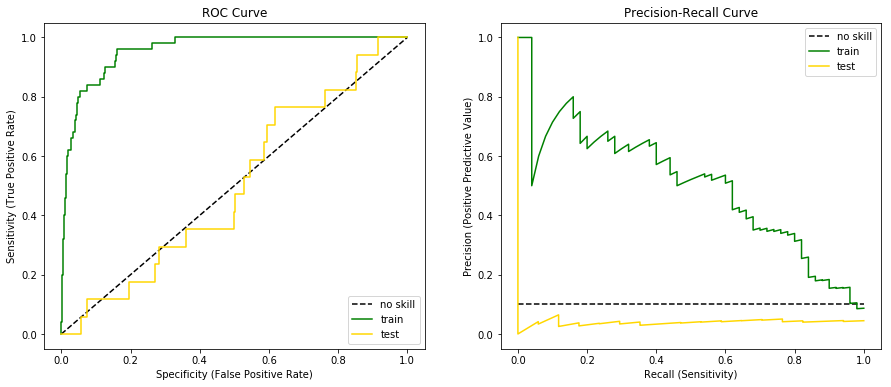

In [77]:
lg = LogisticRegression(solver='lbfgs',
                       max_iter=1000)
lg.fit(X_train_clean_df, y_train)
train_pred = lg.predict_proba(X_train_clean_df)
test_pred = lg.predict_proba(X_test_clean_df)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])

train_p, train_r, train_thresholds = precision_recall_curve(y_train, train_pred[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, test_pred[:,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot([0,1],[0,1], linestyle='--', color='k', label='no skill')
ax1.plot(fpr,tpr, label='train', color='green')
ax1.plot(test_fpr, test_tpr, label='test', color='gold')
ax1.set_xlabel('Specificity (False Positive Rate)')
ax1.set_ylabel('Sensitivity (True Positive Rate)')
ax1.set_title('ROC Curve')
ax1.legend()

ax2.plot([0,1], [0.1,0.1], linestyle='--', color='k', label='no skill')
ax2.plot(train_r, train_p, label='train', color='green')
ax2.plot(recall, precision, label='test', color='gold')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (Positive Predictive Value)')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
plt.show();

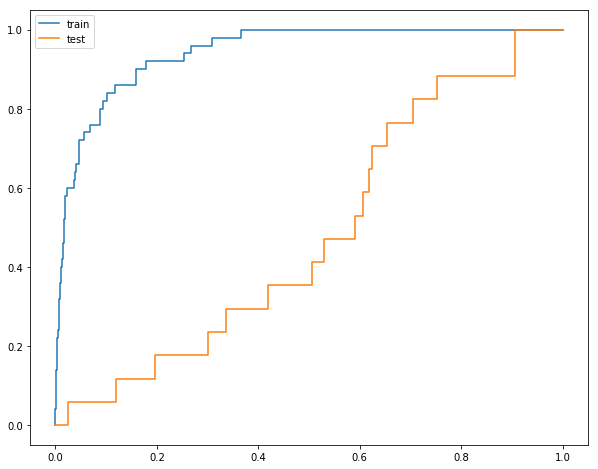

In [32]:
lg = LogisticRegression(penalty='l1',
                       solver='liblinear',
                       max_iter=1000)
lg.fit(X_train_clean_df, y_train)
train_pred = lg.predict_proba(X_train_clean_df)
test_pred = lg.predict_proba(X_test_clean_df)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

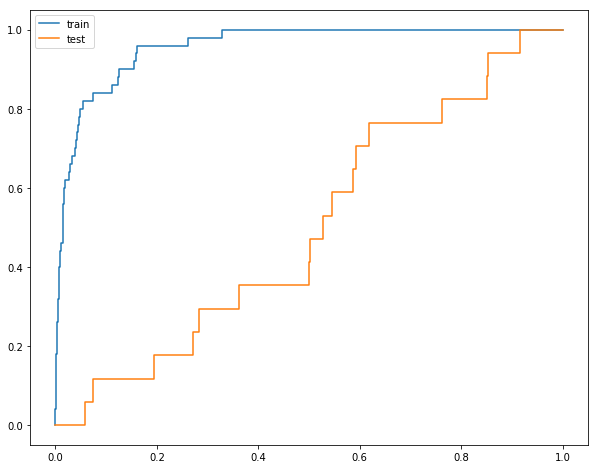

In [33]:
lg = LogisticRegression(penalty='l2',
                       solver='lbfgs',
                       max_iter=1000)
lg.fit(X_train_clean_df, y_train)
train_pred = lg.predict_proba(X_train_clean_df)
test_pred = lg.predict_proba(X_test_clean_df)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [ ]:
rfc = RandomForestClassifier(n_estimators=100,
                             random_state=42,
                             max_depth=4)
rfc.fit(X_train_clean_df, y_train)

#X_test_clean_df

In [ ]:
y_train_pred = rfc.predict_proba(X_train_clean_df)
y_test_pred = rfc.predict_proba(X_test_clean_df)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred[:,1])

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [ ]:
plt.hist(y_test_pred[:,1])

In [ ]:
test_thresholds

In [ ]:
y_test_pred[:,1][:7]

In [ ]:
miles_talk_copy = X_test_clean_df.copy()

In [ ]:
miles_talk_copy['y'] = y_test

In [ ]:
miles_talk_copy['y_pred'] = y_test_pred[:,1]

In [ ]:
miles_talk_copy.sort_values('y_pred', ascending=False).head()

In [ ]:
plt.scatter(miles_talk_copy['y_pred'], miles_talk_copy['y'], alpha=.1)

In [ ]:
test = lg.coef_.tolist()

In [ ]:
coef_df = X_test_clean_df.copy()
X_train_copy = X_train_clean_df.copy()
coef_df['y'] = y_test
coef_df['y_pred'] = test_pred[:,1]

plt.scatter(coef_df['y'], coef_df['y_pred'], alpha=0.1);

In [ ]:
coef_list = list(zip(X_train_clean_df.columns, test[0]))

In [ ]:
coefs_sorted = sorted(coef_list, key= lambda x: x[1], reverse=True)
coefs_sorted

In [ ]:
top_coefs = [x[0] for x in coefs_sorted if abs(x[1]) > 0.5]
best_coef_x_test = coef_df[top_coefs]
best_coef_x_train = X_train_copy[top_coefs]

In [ ]:
lg2 = LogisticRegression(penalty='l2',
                       solver='lbfgs',
                       max_iter=1001)
lg2.fit(best_coef_x_train, y_train)

In [ ]:
train_pred = lg2.predict_proba(best_coef_x_train)
test_pred = lg2.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=100,
                             random_state=42,
                             max_depth=2)
rfc2.fit(best_coef_x_train, y_train)

In [ ]:
train_pred = rfc2.predict_proba(best_coef_x_train)
test_pred = rfc2.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [ ]:
xgb = XGBClassifier(max_depth=2,
                    scale_pos_weight=1,
                    learning_rate=0.1)

xgb.fit(best_coef_x_train, y_train)

In [ ]:
train_pred = xgb.predict_proba(best_coef_x_train)
test_pred = xgb.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [ ]:
h20 = H20